# Dataset Exploration

In [1]:
import os

default_n_threads = 8
os.environ["OPENBLAS_NUM_THREADS"] = f"{default_n_threads}"
os.environ["MKL_NUM_THREADS"] = f"{default_n_threads}"
os.environ["OMP_NUM_THREADS"] = f"{default_n_threads}"

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pgf import FigureCanvasPgf

# Make the interactive backend as PDF
matplotlib.backend_bases.register_backend("pdf", FigureCanvasPgf)

plt.style.use("acmcompat.mplstyle")


def figsize(x, y, two_column=False):
    """Make a figure size with respect to a given width.

    Example:
    --------
    >>> mk_figsize(1, 1)
    (3.3374, 3.3374)
    >>> mk_figsize(1, 2)
    (3.3374, 6.6748)
    >>> mk_figsize(1, 1/3, two_column=True)
    (7.00697, 2.2258)
    """
    columnwidth = 3.3374
    textwidth = 7.00697

    w = textwidth if two_column else columnwidth
    return w * x, w * y


SAVEDIR = "/Users/leo/Workspace/imta/assessment-paper/src/figures/"

In [3]:
import pandas as pd

df_sampled = pd.read_csv("../../data/nfv2/sampled/nb15.csv.gz")
df_full = pd.read_csv("../../data/nfv2/origin/NF-UNSW-NB15-v2.csv.gz")

## RQ0: Is the experiment sound?

Dataset analysis of CICIDS full and sampled. We chose sampled because of the scale of the experiments, but are the results still valid?

## Test methodology
- statistical analysis of the dataset, and comparison of the sampled dataset with the full dataset
  - plot PCA, potentially with colored labels
  - plot correlation matrix
  - plot distribution of labels
- Dispersion analysis (see RQ1) -> interpretability of results

In [7]:
stats_full = df_full["Attack"].value_counts()
stats_full.name = "Full"
stats_sampled = df_sampled["Attack"].value_counts()
stats_sampled.name = "Sampled"


stats = pd.DataFrame(
    [df_sampled["Attack"].value_counts(), df_full["Attack"].value_counts()]
)
stats = stats.T
stats.columns = ["Sampled", "Full"]
stats = pd.concat(
    [
        stats,
        pd.DataFrame(
            {"Sampled": sum(stats["Sampled"]), "Full": sum(stats["Full"])},
            index=["Total"],
        ),
    ]
)
stats

,Sampled,Full
Benign,960078,2295222
Exploits,13187,31551
Fuzzers,9377,22310
Generic,6976,16560
Reconnaissance,5352,12779
DoS,2455,5794
Analysis,969,2299
Backdoor,925,2169
Shellcode,617,1427
Worms,64,164


Text(0.5, 0.0, 'Full dataset')

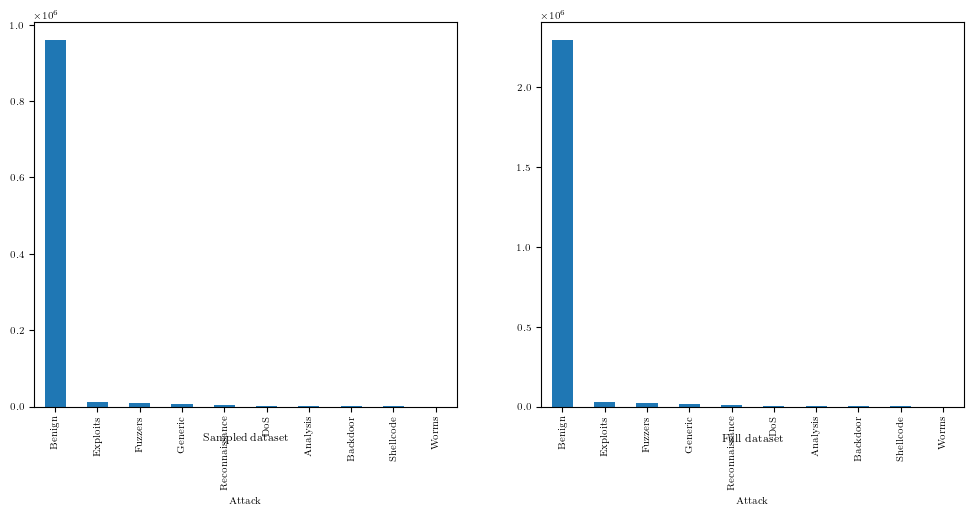

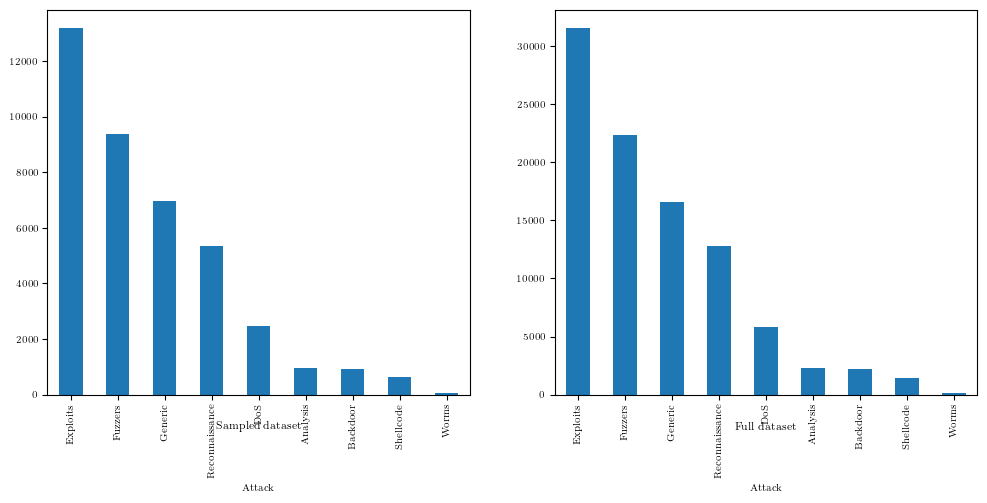

In [8]:
import matplotlib.pyplot as plt

# plot label distribution of both datasets
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
df_sampled["Attack"].value_counts().plot.bar(ax=axs[0])
axs[0].set_title("Sampled dataset")
df_full["Attack"].value_counts().plot.bar(ax=axs[1])
axs[1].set_title("Full dataset")

df_sampled_attack = df_sampled[df_sampled["Label"] == 1]
df_full_attack = df_full[df_full["Label"] == 1]

# plot label distribution wihout benign
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
df_sampled_attack["Attack"].value_counts().plot.bar(ax=axs[0])
axs[0].set_title("Sampled dataset")
df_full_attack["Attack"].value_counts().plot.bar(ax=axs[1])
axs[1].set_title("Full dataset")
# fig.savefig(SAVEDIR + "label-distribution.pgf")

Label distribution is identical (they only differ in magnitude) between sampled and full dataset; the different classes have been correctly sampled.

In [9]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


def prepare(df) -> pd.DataFrame:
    RM_COLS = [
        "IPV4_SRC_ADDR",
        "L4_SRC_PORT",
        "IPV4_DST_ADDR",
        "L4_DST_PORT",
        "Label",
        "Attack",
    ]

    if "Dataset" in df.columns:
        RM_COLS += ["Dataset"]

    # select the columns to compose the Dataset object
    X = df.drop(columns=RM_COLS)

    # convert classes to numerical values
    X = pd.get_dummies(X)

    # normalize the data
    scaler = MinMaxScaler()
    scaler.fit(X)
    X[X.columns] = scaler.transform(X)

    return X


X_sampled = prepare(df_sampled_attack)
X_full = prepare(df_full_attack)
X_sampled.name = "sampled"
X_full.name = "full"

dfs = [
    (X_sampled, df_sampled_attack[["Attack"]]),
    (X_full, df_full_attack[["Attack"]]),
]


pca = PCA(n_components=2)
pcas = np.empty((2, 2), dtype=object)

for i, (from_df, _) in enumerate(dfs):
    frame = pca.fit(from_df)

    for j, (to_df, attack_df) in enumerate(dfs):
        projected = frame.transform(to_df)
        pcas[i, j] = pd.concat(
            [
                pd.DataFrame(
                    data=projected,
                    columns=["pc1", "pc2"],
                ),
                attack_df,
            ],
            axis=1,
        )
        pcas[i, j].name = f"'{from_df.name}' to '{to_df.name}'"

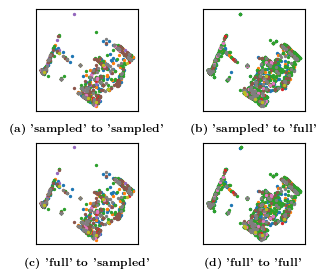

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes

fig, axs = plt.subplots(
    2,
    2,
    figsize=figsize(1, 0.8),
    constrained_layout=True,
)

for i, j in np.ndindex(axs.shape):
    pca_df = pcas[i, j]

    for attack in df_sampled_attack["Attack"].unique():
        df = pca_df[pca_df["Attack"] == attack]
        ax: Axes = axs[i, j]
        ax.scatter(
            df["pc1"],
            df["pc2"],
            label=attack,
            s=2,
            rasterized=True,  # rasterize the points because loading that many points is slow in vector format (even loading the generated PDF)
        )
        ax.set_yticklabels([])
        ax.set_xticklabels([])

    axs[i, j].set_title(pca_df.name)
titles = []
abc = "abcdefghijklmnopqrstuvwxyz"
for ax in axs.flatten():
    letter = abc[axs.flatten().tolist().index(ax)]
    ax.tick_params(labelbottom=True)
    t = ax.set_title(r"\textbf{%s}" % f"({letter}) {ax.get_title()}", pad=-15)
    titles.append(t)
    ax.set_aspect(1.0 / ax.get_data_ratio(), "box")
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)

handles, labels = axs[0, 0].get_legend_handles_labels()

# fig.savefig(
#     SAVEDIR + "pca-projection.pdf",
#     dpi=300,
#     bbox_extra_artists=(*titles,),
#     bbox_inches="tight",
# )

PCA analysis on each dataset produced similar projections.
There are massive overlaps between the classes in this projection (showing either that 2 dimensions are not enough to separate the classes, or that there are features that are not relevant to the classification task).

Yet, the projected patterns are identical between the two datasets.
This means that the sampled dataset is representative of the full dataset.

Additionally, computing the PCA's projection from one dataset and applying it to the other produces the same results.
This emphasizes the fact that the two datasets are similar.

## RQ6: Is model similarity enough to detect poisoning attacks?

In order to prepare for **RQ6** (Is model similarity enough to detect poisoning attacks?), play around with the dataset and understand its characteristics, such as:

- Number of unique IPs
- Attack repartition per IP

In [11]:
df_sampled.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,...,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack,Dataset
0,59.166.0.4,4871,149.171.126.0,21,6,1.0,1251,23,1752,25,...,14480,13568,53,0,0,0,229.0,0,Benign,NF-UNSW-NB15-v2
1,175.45.176.2,29748,149.171.126.11,80,6,7.0,5390,12,336,8,...,16383,55040,215,0,0,0,0.0,1,Exploits,NF-UNSW-NB15-v2
2,59.166.0.6,57069,149.171.126.5,53,17,0.0,146,2,178,2,...,0,0,0,31560,1,60,0.0,0,Benign,NF-UNSW-NB15-v2
3,59.166.0.4,20697,149.171.126.5,61847,6,0.0,3390,56,42312,58,...,14480,8960,35,0,0,0,0.0,0,Benign,NF-UNSW-NB15-v2
4,59.166.0.5,40508,149.171.126.8,25,6,3.0,37290,52,3380,42,...,30408,64768,253,0,0,0,0.0,0,Benign,NF-UNSW-NB15-v2


In [14]:
df_sampled["PROTOCOL"].unique()

array([  6,  17, 206,   1, 227,  89,  45,  21, 131,  35, 214,  56, 228,
       240,  13, 210,  43,  41, 139, 112, 212,  96, 136, 102, 218, 173,
        40, 143, 107,  53,  28, 202, 118, 144, 146,   4,  71,  37, 129,
        92, 246,   8, 142, 222,  26, 241, 237, 170, 253,  76, 169,  78,
        91, 215, 126, 145, 103, 230, 105,   7,  27,  39,  62,  73,  54,
        66,  77, 207, 141, 116,  48,  46,  51,  82, 243, 198, 251, 111,
        16, 189, 151, 147,  68, 117,  79, 155,  95, 120, 236, 180, 109,
       197,  74,  99, 171,  87, 122,  10,  55,  72, 201, 175, 181, 200,
       140,   0,  31, 211, 220, 219, 245,   3, 101, 158,  70, 119, 178,
       148, 159, 167,  80,  50,   5, 213,  20,  47, 184,  59,  11,  85,
        52, 130,  24,  88, 196, 123, 186,  98, 205, 132,  33,   2,  22,
       185, 232, 208, 252, 156, 172,  75, 194, 166,  49, 157, 179,  63,
        25, 183, 242, 138, 108, 239, 121, 176, 174, 235, 137, 229, 188,
        65, 162, 216,  34,   9,  97, 255,  42, 226, 203, 225, 19

In [12]:
protocol_map = {
    6: "TCP",
    17: "UDP",
    1: "ICMP",
    2: "IGMP",  # Internet Group Management Protocol (used for multicast)
    58: "ICMPv6",
    47: "GRE",  # Generic Routing Encapsulation (Cisco tunneling protocol)
}
df_sampled["PROTOCOL"].value_counts().rename(index=protocol_map)

PROTOCOL
TCP     765872
UDP     228005
ICMP       680
89         538
IGMP        49
         ...  
133         12
163         11
19          10
81          10
194          9
Name: count, Length: 255, dtype: int64

In [15]:
df_sampled[df_sampled["Label"] == 0]["L7_PROTO"].round().astype(int).value_counts()[
    lambda x: x > 100
]

L7_PROTO
0      610103
1      196099
7       79943
3       32870
92      20384
4       19778
13        319
17        173
139       127
Name: count, dtype: int64

Text(0.5, 0.98, 'Explained variance ratio of the principal components')

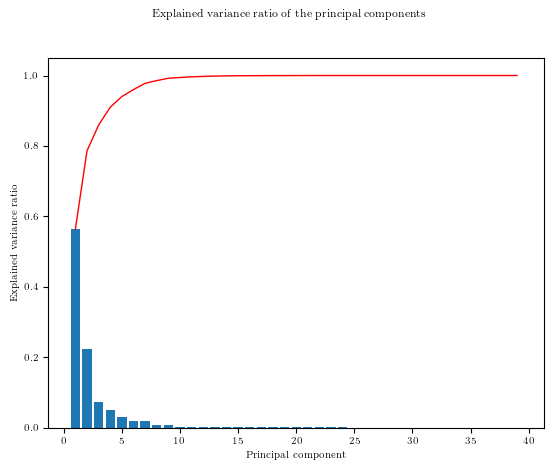

In [16]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


def prepare(df) -> pd.DataFrame:
    RM_COLS = [
        "IPV4_SRC_ADDR",
        "L4_SRC_PORT",
        "IPV4_DST_ADDR",
        "L4_DST_PORT",
        "Label",
        "Attack",
    ]

    if "Dataset" in df.columns:
        RM_COLS += ["Dataset"]

    # select the columns to compose the Dataset object
    X = df.drop(columns=RM_COLS)

    # convert classes to numerical values
    X = pd.get_dummies(X)

    # normalize the data
    scaler = MinMaxScaler()
    # scaler = StandardScaler()
    scaler.fit(X)
    X[X.columns] = scaler.transform(X)

    # NaN values are replaced by 0
    X = X.fillna(0)

    return X


X = prepare(df_sampled[df_sampled["Label"] == 0])

pca = PCA()
pca.fit(X)

fig, ax = plt.subplots()
# plot the explained variance per principal component
ax.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
ax.set_ylabel("Explained variance ratio")
# plot the cumulative explained variance
ax.plot(
    range(1, len(pca.explained_variance_ratio_) + 1),
    pca.explained_variance_ratio_.cumsum(),
    c="red",
)

ax.set_xlabel("Principal component")
fig.suptitle("Explained variance ratio of the principal components")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.98, 'Projection of the benign traffic using PCA (2 components)')

/nix/store/lgxiw09hh1xqxxf83bq2zlkv4dsnhfqk-python3-3.11.3-env/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


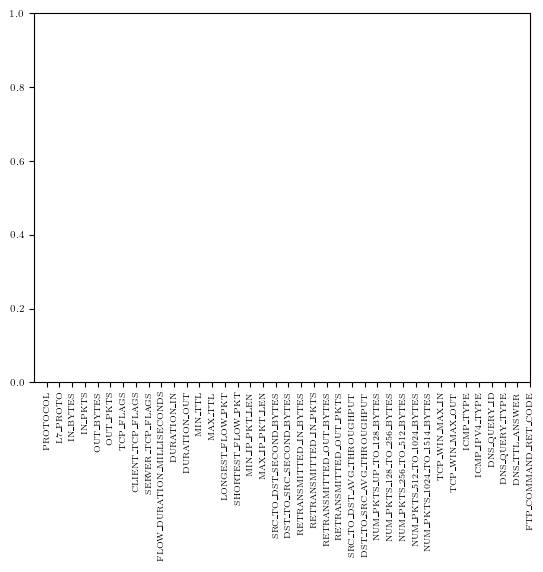

/nix/store/lgxiw09hh1xqxxf83bq2zlkv4dsnhfqk-python3-3.11.3-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


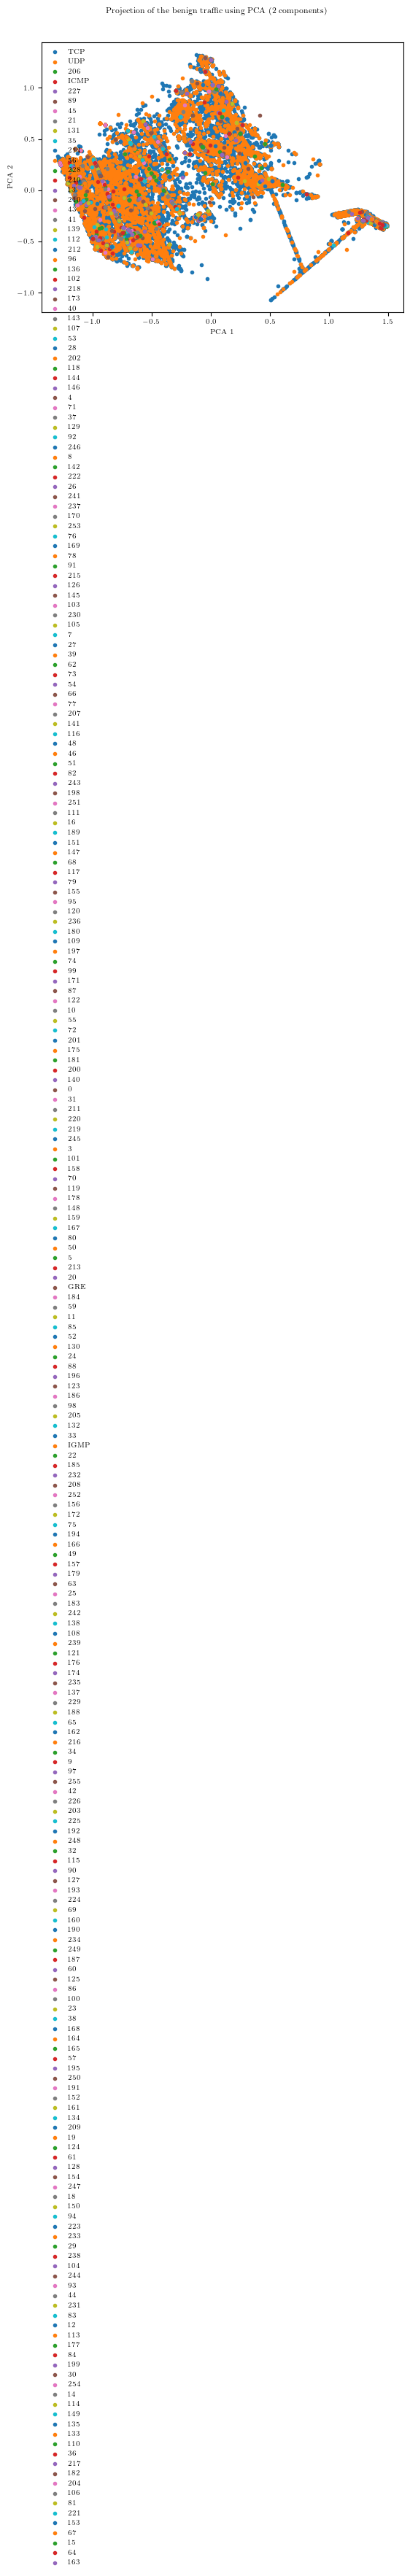

In [17]:
pca = PCA(n_components=2)
pca.fit(X)
# plot the feature importance of the first two components on a grouped bar plot using offset
# one color per component, feature names on x-axis (rotated 90, and small font size to
# fit all features)
fig, ax = plt.subplots()

ax.set_xticks(range(1, len(pca.components_[0]) + 1))
ax.set_xticklabels(X.columns, rotation=90, fontsize=6)
ax.legend()

# plot the pca colored by the protocol
X_pca = pca.transform(X)
X_pca = pd.DataFrame(X_pca, columns=["pca1", "pca2"])

fig, ax = plt.subplots()

for protocol in df_sampled["PROTOCOL"].unique():
    mask = df_sampled["PROTOCOL"] == protocol
    ax.scatter(
        X_pca.loc[mask, "pca1"],
        X_pca.loc[mask, "pca2"],
        label=protocol_map[protocol] if protocol in protocol_map else protocol,
    )
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")

ax.legend()
fig.suptitle("Projection of the benign traffic using PCA (2 components)")

In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=10, init="k-means++", n_init=10)

kmeans.fit(X)
clusters = pd.DataFrame(kmeans.predict(X), columns=["X"])

kmeans.fit(X_pca)
clusters["X_pca"] = kmeans.predict(X_pca)

clusters["X"]

# rand index between "X" and "X_pca"
adjusted_rand_score(clusters["X"], clusters["X_pca"])

0.558713590468015

Text(0.5, 0.98, 'Projection of the benign traffic using PCA (2 components) colored by cluster')

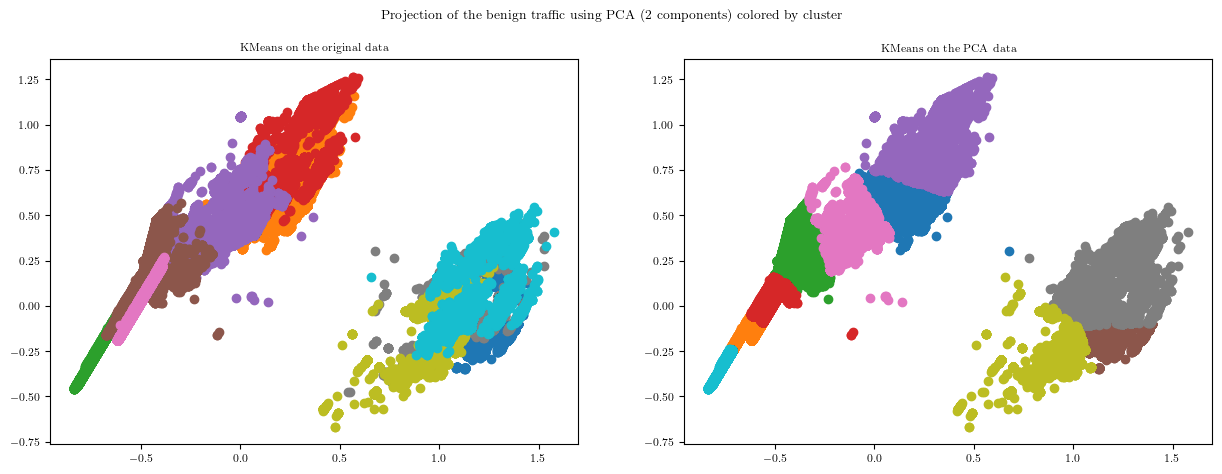

In [26]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 5))

# plot the pca colored by the cluster
for cluster in clusters["X"].unique():
    mask = clusters["X"] == cluster
    ax0.scatter(
        X_pca.loc[mask, "pca1"], X_pca.loc[mask, "pca2"], label=f"Cluster {cluster}"
    )
    ax0.set_title("KMeans on the original data")
    mask = clusters["X_pca"] == cluster
    ax1.scatter(
        X_pca.loc[mask, "pca1"], X_pca.loc[mask, "pca2"], label=f"Cluster {cluster}"
    )
    ax1.set_title("KMeans on the PCA data")


ax.legend()
fig.suptitle(
    "Projection of the benign traffic using PCA (2 components) colored by cluster"
)

In [27]:
# reindex the clusters by size
clusters_map = pd.DataFrame(
    pd.concat(
        [
            pd.Series(clusters["X"].value_counts().sort_values().index),
            pd.Series(clusters["X_pca"].value_counts().sort_values().index),
        ],
        axis=1,
    ),
    columns=["X", "X_pca"],
)

clusters["X"] = clusters["X"].map(
    {v: k for k, v in clusters_map["X"].to_dict().items()}
)
clusters["X_pca"] = clusters["X_pca"].map(
    {v: k for k, v in clusters_map["X_pca"].to_dict().items()}
)

counts = pd.DataFrame(
    [clusters["X"].value_counts(), clusters["X_pca"].value_counts()]
).T
counts.columns = ["X", "X_pca"]
counts.sort_index()

,X,X_pca
0,13954,37056
1,20726,38280
2,33021,54407
3,68767,58786
4,68779,59754
5,74558,84650
6,112392,121220
7,120988,136115
8,179947,145077
9,187491,145278


In [28]:
sum(counts["X"]), sum(counts["X_pca"])

(880623, 880623)

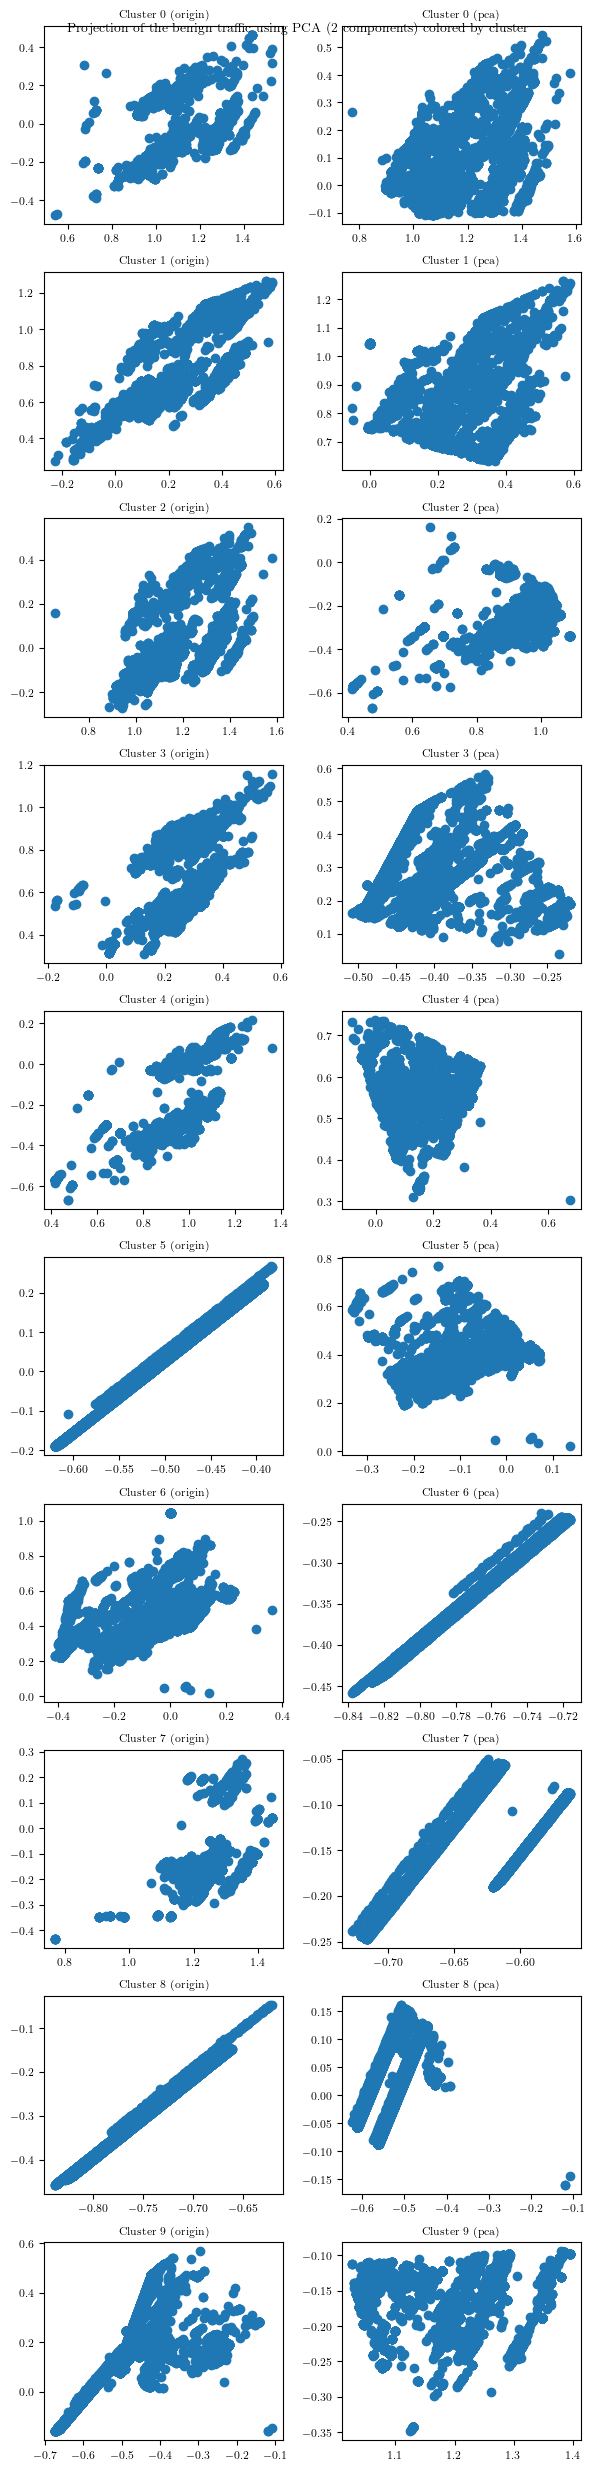

In [29]:
fig, axs = plt.subplots(10, 2, figsize=(6, 25))

for cluster in range(10):
    mask = clusters["X"] == cluster
    axs[cluster, 0].scatter(
        X_pca.loc[mask, "pca1"], X_pca.loc[mask, "pca2"], label=f"Cluster {cluster}"
    )
    axs[cluster, 0].set_title(f"Cluster {cluster} (origin)")
    mask = clusters["X_pca"] == cluster
    axs[cluster, 1].scatter(
        X_pca.loc[mask, "pca1"], X_pca.loc[mask, "pca2"], label=f"Cluster {cluster}"
    )
    axs[cluster, 1].set_title(f"Cluster {cluster} (pca)")

fig.suptitle(
    "Projection of the benign traffic using PCA (2 components) colored by cluster"
)
fig.tight_layout()
plt.show()